### Dataset

In [1]:
!pip install ucimlrepo

#### the libraries

In [169]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import adjusted_rand_score, silhouette_score
import warnings

In [206]:

scaler = MinMaxScaler()

X_final = X_final[selected_features_rfe]

y_binary = (t1> 0).astype(int)
print(y_binary.ndim)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)
print(y_train.shape)
print(y_test.shape)

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}


trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model

1
(242,)
(61,)


In [207]:

results = []

plt.figure(figsize=(8, 6))

for name, model in trained_models.items():

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    y_prob_positive = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(
        y_test,
        y_prob_positive,
        multi_class='ovr',
        average='macro'
    )

    results.append([name, acc, prec, rec, f1, auc_score])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"])
print("📊 Model Comparison (Multi-Class):")
print(results_df.round(3))


📊 Model Comparison (Multi-Class):
                 Model  Accuracy  Precision  Recall     F1    AUC
0  Logistic Regression     0.885      0.884   0.886  0.885  0.953
1        Decision Tree     0.770      0.773   0.774  0.770  0.774
2        Random Forest     0.869      0.868   0.871  0.869  0.938
3                  SVM     0.902      0.904   0.898  0.900  0.955


<Figure size 800x600 with 0 Axes>

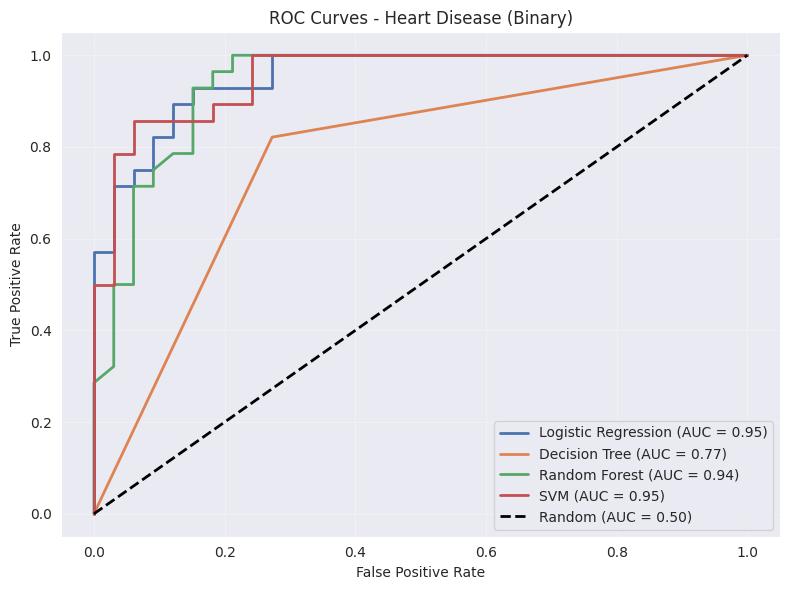

In [235]:

plt.figure(figsize=(8, 6))

for name, model in trained_models.items():
    # Get probability for positive class (class 1)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)  # ✅ Binary: no multi_class

    # Plot
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

# Random line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')

# Labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Heart Disease (Binary)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()